<a href="https://colab.research.google.com/github/luc4t/llm_webapp_api/blob/main/llm_RAG_on_hsbc_uk_bank_local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Local LLM using RAG with HSBC UK Bank dataset
Hi, my name is Vladimir, find implementation of RAG with local LLM.

Answering questions on on [HSBC bank](https://www.hsbc.co.uk/) services using local LLM. Basically assistant that can help users with their questions with the bank.

Google Colab subscription is advised.
T4 GPU is enough. Overall usage is 12GB GPU RAM.

## Installs, imports

In [ ]:
pip install tiktoken FlagEmbedding ctransformers[cuda] huggingface-hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 kB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00
  Created wheel for FlagEmbedding: filename=FlagEmbedding-1.2.5-py3-none-any.whl size=43015 sha256=cf46df77176aff428e12a86fe34f59ba14bfc6f4b1d6c62a37d3ae5fa19a89d8
  Stored in directory: /root/.cache/pip/wheels/3e/b3/70/b

In [ ]:
from ctransformers import AutoModelForCausalLM
from FlagEmbedding import FlagModel, FlagReranker
import re
import tiktoken
import os
import datetime
import numpy as np
import pickle

## HSBC bank dataset
Get hsbc bank dataset from this google drive: https://drive.google.com/file/d/1gFVEzyTBgDmMP48SjySA3skq8nwRxZZw/view?usp=sharing

It is a text file, upload it here using function below.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset_hsbc to dataset_hsbc


In [ ]:
filename = list(uploaded.keys())[0]
with open(filename, 'r') as f:
    document = f.read()

In [ ]:
document_chunks = document.split('########')
print('Number of texts:', len(document_chunks))

Number of texts: 565


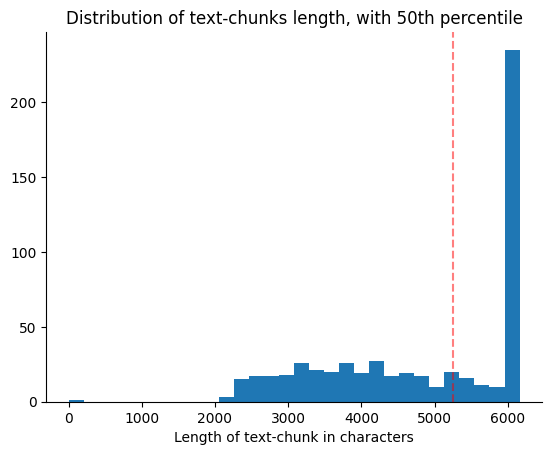

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

chunks_sizes = [len(chunk) for chunk in document_chunks]
percentile_50th = np.percentile(chunks_sizes, 50)
plt.hist(chunks_sizes, bins=30)
plt.title('Distribution of text-chunks length, with 50th percentile')
plt.xlabel('Length of text-chunk in characters')
plt.axvline(x = percentile_50th, color = 'red', linestyle = '--', alpha = 0.5)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show();

## Run local llm
Test simple query

About beluga https://huggingface.co/TheBloke/StableBeluga-7B-GGUF

Documentation on ctransformers https://pypi.org/project/ctransformers/#documentation

Parameters explained https://huggingface.co/blog/how-to-generate

Alternatively how to run locally mistral 7b https://www.automatebard.com/2023/12/18/how-to-get-started-with-mistral-7b-tutorial/

In [ ]:
!huggingface-cli download TheBloke/StableBeluga-7B-GGUF stablebeluga-7b.Q4_K_M.gguf --local-dir . --local-dir-use-symlinks False

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
downloading https://huggingface.co/TheBloke/StableBeluga-7B-GGUF/resolve/main/stablebeluga-7b.Q4_K_M.gguf to /root/.cache/huggingface/hub/tmptj1fg05h
stablebeluga-7b.Q4_K_M.gguf: 100% 4.08G/4.08G [01:26<00:00, 47.4MB/s]
./stablebeluga-7b.Q4_K_M.gguf


In [ ]:
model_path = os.path.abspath('stablebeluga-7b.Q4_K_M.gguf')

In [ ]:
# Documentation says this beluga input token limit is 4096. Define it.
limit_input_tokens = 4096

In [ ]:
llm_ctrans = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True, gpu_layers=100, context_length=limit_input_tokens, model_type='llama', max_new_tokens=1024)

In [ ]:
%%time
answer = llm_ctrans('Who is the smartest animal on Earth?', top_k=40, top_p=0.4, temperature=0.7)
print(answer)


The smartest animal on Earth, according to scientists, is the octopus. These intelligent creatures have been observed solving complex problems and using tools in their natural environment. They are also known for their ability to change color and texture to blend into their surroundings, which helps them avoid predators.
Octopuses are highly adaptable and can learn from experience, making them one of the most intelligent animals on Earth.
CPU times: user 6.17 s, sys: 46.5 ms, total: 6.21 s
Wall time: 4.42 s


This small model answered pretty quickly, utilizing 7GB GPU RAM. The answer is sane.

## RAG (Retrieval Augmented Generation)
Now retriving relevant HSBC information prepare a query for the language model.
1. Define query variable.
2. Encode into embedding space. Retrieve most similar chunks of text.
3. Improve retrieved chunks of text via reranker - rearrange it in an improved order.
4. Cook final query (instructions + best chunks + query) in order to feed it into the language model.

In [ ]:
query = "how do i get student loan"
llm_full_query = ''

Initialize embedding model and reranker beforehand.

In [ ]:
embeddings_model_bge = FlagModel('BAAI/bge-base-en-v1.5',
                       use_fp16=True) # Setting use_fp16 to True speeds up computation with a slight performance degradation

In [ ]:
reranker = FlagReranker('BAAI/bge-reranker-large', use_fp16=True) # Setting use_fp16 to True speeds up computation with a slight performance degradation

## Run RAG

Try bge https://huggingface.co/BAAI/bge-m3 - the best multilangual embeddings according to article https://towardsdatascience.com/openai-vs-open-source-multilingual-embedding-models-e5ccb7c90f05

Try matryoshka https://huggingface.co/blog/matryoshka

Nice article on search via embeddings using cohere https://medium.com/red-buffer/building-a-multilingual-cross-language-semantic-search-engine-using-cohere-76595ebc679e

Try bert embeddings? https://www.analyticsvidhya.com/blog/2023/08/bert-embeddings/

Consider improved bge https://github.com/michaelfeil/infinity

Reranker after retrieval https://github.com/FlagOpen/FlagEmbedding/tree/master/FlagEmbedding/reranker

Explore also: https://github.com/huggingface/text-embeddings-inference

In [ ]:
## encode dataset
embeddings_bge = embeddings_model_bge.encode(document_chunks)

In [ ]:
# save bge embeddings dictionary to person_data.pkl file
with open('embeddings_bge_hsbc.pkl', 'wb') as fp:
    pickle.dump(embeddings_bge, fp)
    print('dictionary saved successfully to file')

In [ ]:
with open('embeddings_bge_hsbc.pkl', 'rb') as fp:
    embeddings_bge = pickle.load(fp)

In [ ]:
bge_RAG_start = datetime.datetime.now()
print(bge_RAG_start)

In [ ]:
emb_bge_query = embeddings_model_bge.encode([query])

In [ ]:
scores = emb_bge_query @ embeddings_bge.T
scores = np.squeeze(scores)

In [ ]:
max_idx = np.argsort(-scores)
max_idx[:8]

In [ ]:
print(f"Query: {query}")
context_chunks_init = []
context_scores = []
for idx in max_idx[:8]:
  print(f"Score: {scores[idx]:.2f}")
  print(document_chunks[idx])
  print("--------")
  context_chunks_init.append(document_chunks[idx])
  context_scores.append(scores[idx])

Now use reranker on the retrieved chunks of text.

In [ ]:
# Test reranker to show it's capabilities. Returns similarity scores. With improved ranks.
scores_test = reranker.compute_score([['what is panda?', 'hi'], ['what is panda?', 'The giant panda (Ailuropoda melanoleuca), sometimes called a panda bear or simply panda, is a bear species endemic to China.']])
print(scores_test)

In [ ]:
# make pairs of query and chunks
query_and_chunks = [[query, chunk] for chunk in context_chunks_init]

In [ ]:
scores_reranker = reranker.compute_score(query_and_chunks)
print(scores_reranker)

In [ ]:
# indexes sorted according to new rank
max_idx_reranked = np.argsort(-np.array(scores_reranker))
print(max_idx_reranked)

In [ ]:
print(f"Query: {query}")
context_chunks = []
for idx in max_idx_reranked:
  print(f"Score: {scores_reranker[idx]:.2f}")
  print(context_chunks_init[idx])
  print("--------")
  context_chunks.append(context_chunks_init[idx])

Order of retrieved chunks improved and became more relevant!

Now define prompt template and create final query from reranked chunks in order to feed it to our local llm.

In [ ]:
prompt_template = """You are a professional consultant at HSBC UK Bank.
Use the context to answer the question at the end.
Give a very detailed answer.
Never mention about context and where information comes from.

Context:
{context}

Question: {question}

Answer:"""

In [ ]:
context_chunks_as_str = '\n###\n'.join([str(elem) for elem in context_chunks])
llm_full_query = prompt_template.format(context=context_chunks_as_str, question=query)

Ensure num of input tokens does not exceed limit.

How to calculate num of tokens: https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb

In [ ]:
encoding = tiktoken.get_encoding("p50k_base")
num_tokens_template = len(encoding.encode(prompt_template))
num_tokens = len(encoding.encode(llm_full_query))
print('num_tokens', num_tokens)

In [ ]:
# The logic checks if highest initial score is high enough (0.45), and is relevant to HSBC Bank services.
# Also more complex logic is implemented to ensure the full llm query does not exceeds input token limit
# i.e. finall llm query is cooked with size < limit_input_tokens
correction_num_of_tokens = 500 # additionally decrease num of tokens by this number

if context_scores[0]<0.45:
  llm_full_query = 'I am HSBC UK Bank assistant and can answer questions related to our Bank. If you have any questions regarding banking services, I will be happy to help. \nPlease formulate your request.'
else:
  num_of_chunks = len(context_chunks)
  for iter in range(num_of_chunks):
    print('context_chunks len:', len(context_chunks))
    context_chunks_as_str = '\n###\n'.join([str(elem) for elem in context_chunks])
    llm_full_query = prompt_template.format(context=context_chunks_as_str, question=query)
    encoding = tiktoken.get_encoding("p50k_base")
    num_tokens_template = len(encoding.encode(prompt_template))
    num_tokens = len(encoding.encode(llm_full_query))
    print('num_tokens', num_tokens)

    if len(context_chunks) == 1 and num_tokens > limit_input_tokens - correction_num_of_tokens:
      chunk_appendix = '\n\nMore details:'
      extracted_link = re.search(r'https://.+', context_chunks[0][-100:]).group(0)
      chunk_appendix = chunk_appendix + ' ' + extracted_link
      num_of_chars_to_cut = num_tokens - limit_input_tokens + num_tokens_template + correction_num_of_tokens
      context_chunks[0] = context_chunks[0][:-num_of_chars_to_cut]
      context_chunks[0] = context_chunks[0] + chunk_appendix
      context_chunks_as_str = '\n###\n'.join([str(elem) for elem in context_chunks])
      llm_full_query = prompt_template.format(context=context_chunks_as_str, question=query)
      num_tokens = len(encoding.encode(llm_full_query))
    elif num_tokens > limit_input_tokens - correction_num_of_tokens:
      print('context_chunks before truncating:', len(context_chunks))
      context_chunks = context_chunks[:-1]
      print('context_chunks after truncating:', len(context_chunks))
      print(iter)

print('Num of context chunks:', len(context_chunks))
encoding = tiktoken.get_encoding("p50k_base")
num_tokens = len(encoding.encode(llm_full_query))
print('Number of tokens in final query: ', num_tokens)

In [ ]:
# Show final query:
#print(llm_full_query)

## Quering the model
Note parameters top_k, top_p, and temperature - can be tuned to improve results.

Parameters explained:
- https://huggingface.co/blog/how-to-generate
- https://www.linkedin.com/pulse/large-language-model-settings-temperature-top-p-max-tokens-albert-mao-0c6ie/

In [ ]:
print('The question:', query)

The question: Give me a hefty loan!


In [ ]:
%%time
answer = llm_ctrans(llm_full_query, top_k=40, top_p=0.4, temperature=0.7)
print(answer)

 You can borrow between £1,000 to £25,000 with fixed monthly payments of up to 60 months for loans up to £15,000, or up to 96 months for loans over £15,000.
CPU times: user 4min 25s, sys: 1min 1s, total: 5min 27s
Wall time: 3min 5s


In [ ]:
llm_answer = answer.strip()
# # Logic to ensure the links are provided at the end of the answer.
llm_answer_appendix = ''
if 'https://' not in llm_answer[-100:]:
  llm_answer_appendix = '\n\nMore details:'
  for chunk in context_chunks[:3] if len(context_chunks)>=4 else context_chunks:
    topic = chunk.split('\n')[1]
    extracted_link = re.search(r'https://.+', chunk[-100:]).group(0)
    llm_answer_appendix = llm_answer_appendix + '\n - ' + topic + ' ' + extracted_link
llm_answer = llm_answer + llm_answer_appendix

print(llm_answer)

You can borrow between £1,000 to £25,000 with fixed monthly payments of up to 60 months for loans up to £15,000, or up to 96 months for loans over £15,000.
More details:
 - Wedding Loans  https://www.hsbc.co.uk/loans/products/wedding-loan/
 - Personal Loan  https://www.hsbc.co.uk/loans/products/personal/
